# Analysis of empirical FC/dFC properties in WMH

## Imports

In [2]:
from __future__ import division, print_function

__author__ = "Gorka Zamora-Lopez"
__email__ = "Gorka.zamora@ymail.com"
__copyright__ = "Copyright 2015"
__license__ = "GPL"
__update__ = "22/11/2015"

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import scipy.signal as signal
import my_functions as my_func
import warnings
import leidenalg as leiden
import copy as cp
import numpy as np
import igraph as ig
import statsmodels.api as sm

from scipy.stats import ranksums
from petTOAD_setup import *
from galib.metrics_numba import FloydWarshall_Numba
from galib import ConnectedComponents
from numpy import trapz
from bct import efficiency_bin, transitivity_bu #Efficiency == Integration, Transitivity == Segregation
from statannotations.Annotator import Annotator

## Define some useful functions

In [3]:
def calculate_avg_fc(group):
    """
    Calculate the average functional connectivity (FC) matrix for a group of subjects.

    Parameters:
    - group (dict): A dictionary where keys are subject identifiers and values are
                   time series data for each subject. Time series data should be in
                   the form of a 2D array, where rows represent regions and
                   columns represent different timepoints.

    Returns:
    - fc_avg_z (numpy.ndarray): The average FC matrix across all subjects, after
                                applying Fisher transform to correlation values.

    Note:
    - The FC matrix is computed by applying a custom function `my_func.fc` to the
      time series of each subject and then averaging the resulting matrices.
    - The correlation of each region with itself is set to 0 to avoid issues with
      Fisher transform (arctanh(1) = inf).
    - The final result is the Fisher-transformed average FC matrix.
    """
    n_subj = len(group)
    N = group[next(iter(group))].shape[0]
    fc_group = np.zeros([N, N])
    for _, ts in group.items():
        fc_group += my_func.fc(ts)
    fc_avg = fc_group / n_subj
    # Change correlation with itself to 0, otherwise arctanh(1) = inf
    np.fill_diagonal(fc_avg, 0)
    # Fisher transform
    fc_avg_z = np.arctanh(fc_avg)

    return fc_avg_z

def plot_avg_fc(name_1, fc1, name_2, fc2):
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(fc1)
    axs[0].set_title(f"{name_1}")
    axs[1].imshow(fc2)
    axs[1].set_title(f"{name_2}")
    plt.show()


def process_group_avg_fc(fc_avg_1, fc_avg_2):
    # Calculate pairwise differences between conditions
    pairwise_diff = fc_avg_1 - fc_avg_2

    # Calculate global FC as the mean absolute (so to also consider negative correlations) value of the FC matrix across all pairs of areas
    N = fc_avg_1.shape[0]
    glob_fc_1 = (np.sum(np.abs(fc_avg_1), axis=1) - 1) / N
    glob_fc_2 = (np.sum(np.abs(fc_avg_2), axis=1) - 1) / N

    # Calculate node strength as the sum over columns of the sFC matrix
    node_strength_1 = np.sum(fc_avg_1, axis=0)
    node_strength_2 = np.sum(fc_avg_2, axis=0)

    # Calculate node diversity as the standard deviation over columns of the sFC matrix
    node_diversity_1 = np.std(fc_avg_1, axis=0)
    node_diversity_2 = np.std(fc_avg_2, axis=0)

    # Test differences in pairwise, node, and global metrics across conditions using a Wilcoxon ranksum test
    pairwise_pvalue = ranksums(pairwise_diff.flatten(), np.zeros(pairwise_diff.size))[1]
    node_strength_pvalue = ranksums(node_strength_1, node_strength_2)[1]
    node_diversity_pvalue = ranksums(node_diversity_1, node_diversity_2)[1]
    global_fc_pvalue = ranksums(glob_fc_1.flatten(), glob_fc_2.flatten())[1]

    # Apply Bonferroni correction for multiple comparisons
    n_pairs = N * (N - 1) / 2
    pairwise_alpha = 0.05 / n_pairs
    node_alpha = 0.05 / fc_avg_1.shape[0]
    global_alpha = 0.05 / fc_avg_1.shape[0]

    if pairwise_pvalue < pairwise_alpha:
        print(
            f"Pairwise differences are significant, p-value: {round(pairwise_pvalue, 5)} < {pairwise_alpha}"
        )
    else:
        print(
            f"Pairwise differences are not significant, p-value: {round(pairwise_pvalue, 5)} > {pairwise_alpha}"
        )

    if node_strength_pvalue < node_alpha:
        print(
            f"Node strength differences are significant, p-value: {round(node_strength_pvalue, 5)} < {node_alpha}"
        )
    else:
        print(
            f"Node strength differences are not significant, p-value: {round(node_strength_pvalue, 5)} > {node_alpha} "
        )

    if node_diversity_pvalue < node_alpha:
        print(
            f"Node diversity differences are significant. p-value: {round(node_diversity_pvalue, 5)} < {node_alpha}"
        )
    else:
        print(
            f"Node diversity differences are not significant, p-value: {round(node_diversity_pvalue, 5)} > {node_alpha}"
        )

    if global_fc_pvalue < global_alpha:
        print(
            f"Global FC differences are significant, p-value: {round(global_fc_pvalue, 5)} < {global_alpha}"
        )
    else:
        print(
            f"Global FC differences are not significant, p-value: {round(global_fc_pvalue, 5)} > {global_alpha}"
        )

    return [glob_fc_1, node_strength_1, node_diversity_1], [
        glob_fc_2,
        node_strength_2,
        node_diversity_2,
    ]

### Functions according to Gustavo Patow's Whole Brain module (based on Gustavo Deco's Code)

In [4]:
def IntegrationFromFC_Fast(fcmatrix, nbins=50, datarange=[0,1]):
    """Calculates integration from a correlation(-like) matrix.

    FASTER VERSION. In this case I start the thresholding from the higher values.
    The moment the algorithm finds a threshold with a unique giant component,
    then, for any lower thresholds there is no need to repeat the calculation
    because all subsequent cases we will find a unique component.

    Given a functional connectivity (FC) matrix, e.g. a matrix of pair-wise
    Pearson correlations, this function does the following:
    1) It creates a series of binary graphs by thresholding the FC matrix along
    several thresholds, from 0 to 1.
    2) It finds the giant component of each binarised graphs, at each threshold.
    3) Computes 'integration' as the area under-the-curve for the curve defined
    by the sizes of the largest components along the thresholds. See,
    "Deco, G., Tononi, G., Boly, M. et al. Rethinking segregation and
    integration: contributions of whole-brain modelling. Nat Rev Neurosci 16,
    430–439 (2015). https://doi.org/10.1038/nrn3963"

    Parameters
    ----------
    fcmatrix : ndarray of rank-2.
        A pair-wise functional connectivity matrix, e.g., Pearson correlation or
        a level of pair-wise synchrony between brain regions.
    nbins : integer (optional)
        Number of bins for which the distribution of values in the matrix shall
        be estimated.
    datarange : list, tuple or array_like (optional)
        A sequence of length = 2 containing the smallest and the largest values
        expected in the statistical association matrix.

    Returns
    -------
    fcintegration : scalar
        The integration value, ranging from 0 to 1.
    Notes:
    - Taken from Gustavo Patow's WholeBrain @ github.com/dagush/WholeBrain
    """
    # 0) Security checks
    wmin, wmax = datarange[0], datarange[1]
    if len(np.shape(fcmatrix)) != 2:
        raise ValueError( "Input data not a matrix. Data not alligned." )
    if fcmatrix.min() < wmin:
        raise ValueError( "Input data not in range. Values smaller than range found." )
    if fcmatrix.max() > wmax:
        raise ValueError( "Input data not in range. Values larger than range found." )

    N = len(fcmatrix)
    diagidx = np.diag_indices(N)

    stepsize = (wmax - wmin) / nbins
    threslist = np.arange(wmin,wmax,stepsize)

    # 1) Iterate over all thresholds and find the giant component for each case
    giantsizelist = np.zeros(nbins, np.float64)
    # Start thresholding from the largest values
    for i, thres in enumerate(threslist[::-1]):
        # Threshold the FC matrix
        bimatrix = np.where(fcmatrix > thres, 1,0).astype(float)
        bimatrix[diagidx] = 0
        # Calculate the pair-wise graph distance matrix
        dij = FloydWarshall_Numba(bimatrix)
        # Find the connected components and get the size of the largest one
        components = ConnectedComponents(dij, directed=False, showall=False)
        # If all nodes are isolated
        if not components:
            giantsizelist[i] = 0
        # Look for the size of the largest component
        else:
            maxsize = 0
            for comp in components:
                if len(comp) > maxsize:
                    maxsize = len(comp)
            giantsizelist[i] = maxsize
            # If whole net is one component, no need to check further thresholds.
            if maxsize == N:
                giantsizelist[i:] = N
                break

        #print(i, thres, giantsizelist[i])
    # print( giantsizelist )

    # 2) Calculate the integration (area-under-the-curve)
    fcintegration = giantsizelist.sum() * stepsize
    # Normalise to a value from 0 to 1
    fcintegration /= N

    return fcintegration

# @jit(nopython=True)
def metastability(ts_emp, applyFilters=False):  
    """
    Calculate empirical metastability and synchrony from fMRI time series data.

    Parameters:
    - ts_emp (numpy.ndarray): 2D array containing fMRI time series data.
    - applyFilters (bool): Whether to apply bandpass filters to the time series data. Default is False.

    Returns:
    - meta_emp_all (float): Empirical metastability measure.
    - meta_synch_all (float): Empirical synchrony measure.

    Notes:
    - The function calculates metastability and synchrony based on the provided fMRI time series data.
    - Metastability is computed as the standard deviation of the Kuramoto order parameter across time points.
    - Synchrony is measured as the mean absolute value of the Kuramoto order parameter.
    - Taken from Gustavo Patow's WholeBrain @ github.com/dagush/WholeBrain
    """
    def demean(x,dim=0):
        import numpy.matlib as mtlib
        dims = x.size
        return x - mtlib.tile(np.mean(x,dim), dims)  # repmat(np.mean(x,dim),dimrep)

    # --------------------------------------------------------------------------
    # for isub=1:nsub
    #     for inode=1:nnodes
    #         ts_emp_sub(inode,:)=detrend(ts_emp(inode,:,isub)-mean(ts_emp(inode,:,isub)));
    #         ts_emp_filt(inode,:,isub)=filtfilt(bfilt,afilt,ts_emp_sub(inode,:));
    #         % pw = abs(fft(ts_emp_filt(inode,:,isub)));
    #         % PowSpect(:,inode,isub) = pw(1:floor(Tmax/2)).^2/(Tmax/Cfg.TRsec);
    #         Xanalytic(inode,:) = hilbert(demean(ts_emp_filt(inode,:,isub)));
    #         phases_emp(inode,:,isub) = angle(Xanalytic(inode,:));              % <--
    #     end
    #
    #     T=10:Tmax-10;
    #     sync = zeros(1, numel(T));
    #     for t=T
    #         ku=sum(complex(cos(phases_emp(:,t,isub)),sin(phases_emp(:,t,isub))))/nnodes;
    #         sync(t-9)=abs(ku);
    #     end
    #     % empirical metastability
    #     meta_emp_all(isub)=std(sync(:));
    #     % fc_emp_all(:,:,isub) = corrcoef(ts_emp_filt(:,:,isub)');
    #     % phfcd_emp_all(:,isub)=patternCons(phases_emp(:,:,isub),nnodes,Tmax);
    # end
    # --------------------------------------------------------------------------
    (N, Tmax) = ts_emp.shape
    npattmax = Tmax - 19  # calculates the size of phfcd vector
    # size_kk3 = int((npattmax - 3) * (npattmax - 2) / 2)  # The int() is not needed because N*(N-1) is always even, but "it will produce an error in the future"...

    if not np.isnan(ts_emp).any():  # No problems, go ahead!!!
        if applyFilters:
            # Filters seem to be always applied...
            ts_emp_filt = BOLDFilters.BandPassFilter(ts_emp)  # zero phase filter the data

        # Data structures we are going to need...
        phases_emp = np.zeros([N, Tmax])
        # sync = np.zeros(npattmax)

        for n in range(N):
            Xanalytic = signal.hilbert(demean(ts_emp[n, :]))
            phases_emp[n, :] = np.angle(Xanalytic)

        T = np.arange(10, Tmax - 10 + 1)
        sync = np.zeros(T.size)
        for t in T:
            ku = np.sum(np.cos(phases_emp[:, t - 1]) + 1j * np.sin(phases_emp[:, t - 1])) / N
            sync[t - 10] = abs(ku)

        # empirical metastability
        meta_emp_all = np.std(sync)
        # empirical synchrony
        meta_synch_all = np.mean(sync)
    else:
        warnings.warn(f'############ Warning!!! Metastability.from_fMRI: NAN found ############')
        meta_emp_all = np.nan
        meta_synch_all = np.nan

    return meta_emp_all, meta_synch_all


def Array2iGraph(adjmatrix, weighted=False):
    """Converts a 2D numpy array into an iGraph graph object.

    The function automatically detects whether the input network is directed,
    or is undirected but contains asymmetric weights.

    Parameters
    ----------
    adjmatrix : ndarray of rank-2
        The adjacency matrix of the network. Weighted links are ignored.
    weighted : boolean (optional)
        Specifies whether the network is weighted or not.

    Returns
    -------
    iggraph : graph object recognised by iGraph.
        The graph representation of the adjacency matrix with corresponding
        un/directed and/or un/weighted properties.
    """
    # 0) Security check
    assert len(np.shape(adjmatrix)) == 2, \
        'Input array not an adjacency matrix. Array dimension has to be 2.'

    # 1) Find out whether the network is directed or has asymmetric weights
    diff = np.abs(adjmatrix - adjmatrix.T)
    if diff.max() > 10**-6: directed = True
    else: directed = False
    del diff

    # 2) Declare the igraph graph object
    N = len(adjmatrix)
    iggraph = ig.Graph()

    # 2.1) Add the nodes
    iggraph.add_vertices(N)

    # 2.2) Add the links if the network is DIRECTED
    if directed:
        # Make the graph directed
        iggraph.to_directed()

        # Create a list with the links.
        idx = np.where(adjmatrix)
        links = []
        for l in range(len(idx[0])):
            links.append( (idx[0][l],idx[1][l]) )

        # Add the links in the graph.
        iggraph.add_edges(links)

        # If the network is directed, include the weights.
        if weighted:
            values = adjmatrix[idx]
            iggraph.es[:]['weight'] = values

    # 2.2) Add the links if the network is UNDIRECTED
    else:
        # Make a copy of the adjacency matrix to be modified.
        newadjmatrix = adjmatrix.copy()
        idx = np.triu_indices(N,k=1)
        newadjmatrix[idx] = 0

        # Create a list with the links.
        idx = np.where(newadjmatrix)
        links = []
        for l in range(len(idx[0])):
            links.append( (idx[0][l],idx[1][l]) )

        # Add the links in the graph.
        iggraph.add_edges(links)

        # If the network is directed, include the weights.
        if weighted:
            values = newadjmatrix[idx]
            iggraph.es[:]['weight'] = values

        # Clean trash
        del newadjmatrix

    return iggraph


def computeSegregation(fcnet):
    name = 'Segregation'
    # Useful definitions, from Gorka's code
    # wcase = 'Binary'    # Binary, Weighted
    Qmethod = 'RB'         # RB, RBER
    corrdiagonals = 'noDiags'     # 'Diags', 'noDiags'
    nruns = 20
    resolparam = 1.0
    # savedata = False
    N, N = np.shape(fcnet)
    # Remove the diagonal entries -- Optional
    if corrdiagonals == 'noDiags':
        fcnet[np.diag_indices(N)] = 0
    # Normalise the weights such that total weight is always the same (N)
    if fcnet.sum() > 0:
        fcnet = fcnet/fcnet.sum() * N
    # Finally, convert to igraph object
    fcignet = Array2iGraph(fcnet, weighted=True)

    # 2.2) Find the partition
    Qmax = -np.inf
    for re in range(nruns):
        # Usual Newman modularity but accepting a resolution parameter
        if Qmethod == 'RB':
            temppartition = leiden.find_partition(fcignet, leiden.RBConfigurationVertexPartition,
                                                  weights='weight', resolution_parameter=resolparam)
        # The usual Newman modularity
        elif Qmethod == 'Modularity':  # Use in the case of binarized matrices...
            temppartition = leiden.find_partition(fcignet, leiden.ModularityVertexPartition,
                                                  weights='weight')
        # Cost function based on random graphs or matrices.
        elif Qmethod == 'RBER': # Use for weighted matrices...
            temppartition = leiden.find_partition(fcignet, leiden.RBERVertexPartition,
                                                  weights='weight', resolution_parameter=resolparam)
        Qtemp = temppartition.quality()
        if Qtemp >= Qmax:
            Qmax = Qtemp
            partition = cp.copy(temppartition)

    if np.isnan(Qtemp):
        Qmax = 0.0
        partition = cp.copy(temppartition)
    return Qmax, partition


def calculate_int_seg_met_synch(dict_timeseries):
    """
    Calculate integration and segregation, metastability, and synchrony measures according to code from Gustavo Patow's
    Whole Brain and merge them with the project DataFrame.

    Parameters:
    - dict_timeseries: A dictionary where keys are subject identifiers and values are time series data.

    Returns:
    - df_petTOAD_meta_synchr: DataFrame containing merged measures for each subject.

    This function takes a dictionary of time series data as input and calculates various measures, including
    metastability, synchrony, integration, and segregation for each subject.
    The calculated measures are then merged with the project DataFrame ('df_petTOAD') containing additional
    information about the subjects, and the result is saved to a new CSV file.

    Example Usage:
    ```
    # Assuming dict_timeseries is a dictionary of time series data
    df_result = calculate_int_seg_met_synch(dict_timeseries)
    ```

    Note: The function relies on external functions 'my_func.fc', 'metastability', 'IntegrationFromFC_Fast',
    and 'computeSegregation', which are assumed to be defined and available in the global scope.

    """
    # Initialize empty lists to store data
    subject_list = []
    metastability_list = []
    synchrony_list = []
    integration_list = []
    segregation_list = []

    # Loop through subjects and calculate measures
    for subj in dict_timeseries.keys():
        ts = dict_timeseries[subj]
        fc = my_func.fc(ts)
        abs_fc = np.abs(fc)

        # Append calculated measures to the lists
        subject_list.append(subj)
        metastability_list.append(metastability(ts)[0])
        synchrony_list.append(metastability(ts)[1])
        integration_list.append(IntegrationFromFC_Fast(abs_fc))
        segregation_list.append(computeSegregation(abs_fc)[0])

    # Create a DataFrame from the lists
    df_measures = pd.DataFrame({
        "PTID": subject_list,
        "metastability": metastability_list,
        "synchrony": synchrony_list,
        "integration": integration_list,
        "segregation": segregation_list,
    })

    # Merge the calculated measures with the original DataFrame
    df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col=0)
    df_petTOAD_meta_synchr = pd.merge(df_petTOAD, df_measures, on="PTID")

    # Save the new DataFrame with additional measures to a CSV file
    df_petTOAD_meta_synchr.to_csv(RES_DIR / "df_petTOAD_with_fc_measures.csv")

    # Return the merged DataFrame
    return df_petTOAD_meta_synchr


### Functions according to Coronel-Oliveros et al, NeuroImage, 2023

In [5]:
# Methods taken from Coronel-Oliveros et al, NeuroImage, 2023 (https://doi.org/10.1016/j.neuroimage.2022.119782)
# Code taken from https://github.com/vandal-uv/Nicotine-Whole-Brain

def binarize(W, copy = True):
    """
    Binarizes an input weighted connection matrix.  If copy is not set, this
    function will *modify W in place.*
    Parameters
    ----------
    W : NxN :obj:`numpy.ndarray`
        weighted connectivity matrix
    copy : bool
        if True, returns a copy of the matrix. Otherwise, modifies the matrix
        in place. Default value=True.
    Returns
    -------
    W : NxN :obj:`numpy.ndarray`
        binary connectivity matrix
    """
    if copy:
        W = W.copy()
    W[W != 0] = 1
    # W = W.astype(int)  # causes tests to fail, but should be included
    return(W)


def invert(W, copy = True):
    """
    Inverts elementwise the weights in an input connection matrix.
    In other words, change the from the matrix of internode strengths to the
    matrix of internode distances.
    If copy is not set, this function will *modify W in place.*
    Parameters
    ----------
    W : :obj:`numpy.ndarray`
        weighted connectivity matrix
    copy : bool
        if True, returns a copy of the matrix. Otherwise, modifies the matrix
        in place. Default value=True.
    Returns
    -------
    W : :obj:`numpy.ndarray`
        inverted connectivity matrix
    """
    if copy:
        W = W.copy()
    E = np.where(W)
    W[E] = 1. / W[E]
    return(W)


def get_uptri(x):
    nnodes = x.shape[0]
    npairs = (nnodes**2 - nnodes) // 2
    vector = np.zeros(npairs)
    
    idx = 0
    for row in range(0, nnodes - 1):
        for col in range(row + 1, nnodes):
            vector[idx] = x[row, col]
            idx = idx + 1
    
    return(vector)


def matrix_recon(x):
    npairs = len(x)
    nnodes = int((1 + np.sqrt(1 + 8 * npairs)) // 2)
    
    matrix = np.zeros((nnodes, nnodes))
    idx = 0
    for row in range(0, nnodes - 1):
        for col in range(row + 1, nnodes):
            matrix[row, col] = x[idx]
            idx = idx + 1
    matrix = matrix + matrix.T
   
    return(matrix)   

def thresholding(x, threshold = 0.20, zero_diag = True, direct = 'undirected'):
    nnodes = x.shape[0]
    if zero_diag == True:
        np.fill_diagonal(x, 0)
    
    if direct == 'directed':
        nlinks = nnodes**2 - nnodes
        x_vector = x.reshape((1, nnodes**2))
        to_get_links = int(nlinks * threshold)
        sorting = np.argsort(x_vector)[0,::-1]
        selection = sorting[0:to_get_links]
        to_delete = np.delete(np.arange(0, nnodes**2, 1), selection)
        x_thresholded = np.copy(x_vector[0,:])
        x_thresholded[to_delete] = 0
        x_thresholded = x_thresholded.reshape((nnodes, nnodes))
    elif direct == 'undirected':
        nlinks = (nnodes**2 - nnodes) // 2
        x_vector = get_uptri(x)
        to_get_links = int(nlinks * threshold)
        sorting = np.argsort(x_vector)[::-1]
        selection = sorting[0:to_get_links]
        to_delete = np.delete(np.arange(0, nlinks, 1), selection)
        x_vector[to_delete] = 0
        x_thresholded = matrix_recon(x_vector)
    else:
        print('Invalid type of matrix -> direct options: undirected or directed')
    
    return(x_thresholded)

# Function to calculate integration and segregation measures for each subject
def calc_int_seg(dict_timeseries, thresholds):
    """
    Calculate integration and segregation measures for each subject at various threshold levels according to Coronel-Oliveros'
    paper, NeuroImage 2023.

    Parameters
    ----------
    - dict_timeseries: a dictionary containing subject_name: time_series

    Returns:
    ----------
    - df_int_seg: DataFrame containing integration and segmentation measures for all subjects.
    
    This function iterates through the keys of a dictionary containing subject names' and corresponding timeseries.
    For each subject, it calculates functional connectivity matrices at different threshold levels and computes
    corresponding efficiency (integration) and transitivity (segregation). The results are then
    stored in a DataFrame and saved to a CSV file named "df_int_seg.csv" in the directory specified by the 'RES_DIR'
    global variable.

    If the CSV file already exists, it attempts to read the data from the file instead of recalculating it.

    Note: The function relies on external functions 'my_func.fc', 'thresholding', 'efficiency_bin', and 'transitivity_bu',
    which are assumed to be defined and available in the global scope.

    Example Usage:
    ```
    try:
        df_int_seg = pd.read_csv(RES_DIR / "df_int_seg.csv", index_col=0)
    except:
        df_int_seg = calc_int_seg()
    ```

    """

    # Initialize lists to store data
    list_all_subjs = []
    list_all_efficiency = []
    list_all_transitivity = []
    list_all_thresh = []

    # Loop through subjects
    for subj in dict_timeseries.keys():
        ts = dict_timeseries[subj]
        list_efficiency = []
        list_transitivity = []
        subj_repeat = []

        # Loop through threshold values
        for thresh in thresholds:
            fc = my_func.fc(ts)
            fc_thresh = thresholding(fc, threshold=thresh)
            list_efficiency.append(efficiency_bin(fc_thresh))
            list_transitivity.append(transitivity_bu(fc_thresh))
            subj_repeat.append(subj)

        # Append data to the lists
        list_all_efficiency.append(list_efficiency)
        list_all_transitivity.append(list_transitivity)
        list_all_thresh.append(thresholds)
        list_all_subjs.append(subj_repeat)

        # Create a DataFrame from the lists
        df_int_seg = pd.DataFrame({
            "PTID": [pt for sublist in list_all_subjs for pt in sublist],
            "Thresh": [thresh for sublist in list_all_thresh for thresh in sublist],
            "Efficiency": [eff for sublist in list_all_efficiency for eff in sublist],
            "Transitivity": [trans for sublist in list_all_transitivity for trans in sublist]
        })

        # Remove rows with threshold value 0 to eliminate NaNs
        df_int_seg = df_int_seg[df_int_seg["Thresh"] != 0]

        # Save the DataFrame to a CSV file
        df_int_seg.to_csv(RES_DIR / "df_int_seg.csv")

    # Return the DataFrame
    return df_int_seg

def calc_auc(parm, thresholds):
    """
    Calculate the area under the curve (AUC) for a given parameter and its corresponding thresholds.

    Parameters:
    - parm: A list or array representing the values of the parameter at different thresholds (e.g., ).
    - thresholds: A list or array representing the threshold values corresponding to the parameter.

    Returns:
    - area: A float representing the calculated area under the curve.

    This function calculates the area under the curve (AUC) for a given parameter and its corresponding thresholds
    using the trapezoidal rule. It takes two input arrays/lists: 'parm' containing the parameter values (y-values) and 'thresholds'
    containing the corresponding threshold values (x-axis).

    Note: The function uses the trapezoidal rule for numerical integration, and the input arrays/lists are assumed to be
    sorted in ascending order.

    """
    y_parm = parm
    dx = thresholds[1] - thresholds[0]
    area = trapz(y=y_parm, dx=dx)
    return area

## Data preparation

In [6]:
# Read the project CSV file into a DataFrame
df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col=0)

# Calculate quartiles for the "WMH" column
wmh_q1 = np.quantile(df_petTOAD["WMH_load_subj_space"], 0.25)
wmh_q2 = np.quantile(df_petTOAD["WMH_load_subj_space"], 0.5)
wmh_q3 = np.quantile(df_petTOAD["WMH_load_subj_space"], 0.75)

# Create a new column "WMH_bin" based on the "Group_bin_Fazekas" column
df_petTOAD["WMH_bin"] = np.where(df_petTOAD["Group_bin_Fazekas"].str.contains("no"), "no_WMH", "WMH")

# Create a new column "wmh_bin_quant" and categorize values based on quartiles
df_petTOAD["wmh_bin_quant"] = np.nan
df_petTOAD["wmh_bin_quant"] = np.where(df_petTOAD["WMH_load_subj_space"] < wmh_q1, "q1", df_petTOAD["wmh_bin_quant"])
df_petTOAD["wmh_bin_quant"] = np.where((df_petTOAD["WMH_load_subj_space"] >= wmh_q1) & (df_petTOAD["WMH_load_subj_space"] < wmh_q2), "q2", df_petTOAD["wmh_bin_quant"])
df_petTOAD["wmh_bin_quant"] = np.where((df_petTOAD["WMH_load_subj_space"] >= wmh_q2) & (df_petTOAD["WMH_load_subj_space"] < wmh_q3), "q3", df_petTOAD["wmh_bin_quant"])
df_petTOAD["wmh_bin_quant"] = np.where((df_petTOAD["WMH_load_subj_space"] >= wmh_q3), "q4", df_petTOAD["wmh_bin_quant"])

# Calculate the total Fazekas score and convert it to string
df_petTOAD["Fazekas_total"] = df_petTOAD["Fazekas_lobar"] + df_petTOAD["Fazekas_periventricular"]
df_petTOAD["Fazekas_total"] = df_petTOAD["Fazekas_total"].astype(str)

# Try to read the metastability + integration + synchrony dataframe (if already calculated), otherwise calculate and append measures
try:
    df_petTOAD_meta_synchr = pd.read_csv(RES_DIR / "df_petTOAD_with_fc_measures.csv", index_col=0)
    df_int_seg = pd.read_csv(RES_DIR / "df_int_seg.csv", index_col=0)
    # For some reasons when loading, it loads Fazekas as float, we convert to string
    df_int_seg["Fazekas_total"] = df_int_seg["Fazekas_total"].astype(str)
    df_petTOAD_meta_synchr["Fazekas_total"] = df_petTOAD_meta_synchr["Fazekas_total"].astype(str)
    list_thresh = np.linspace(0., 1, 101).tolist()

except:
    df_petTOAD_meta_synchr = calculate_int_seg_met_synch(all_fMRI_clean)
    # Generate a list of 101 evenly spaced values between 0 and 1 to use as thresholds (increase of 0.01) 
    list_thresh = np.linspace(0., 1, 101).tolist()
    df_int_seg = calc_int_seg(all_fMRI_clean, list_thresh)
    df_int_seg = pd.merge(df_int_seg, df_petTOAD[["PTID", "WMH_bin", "Group_bin_Fazekas", "Fazekas_total", "WMH_load_subj_space", "wmh_bin_quant"]], on = "PTID")    
    df_int_seg.to_csv(RES_DIR / "df_int_seg.csv")

## Analyses

### Integration-segregation paper

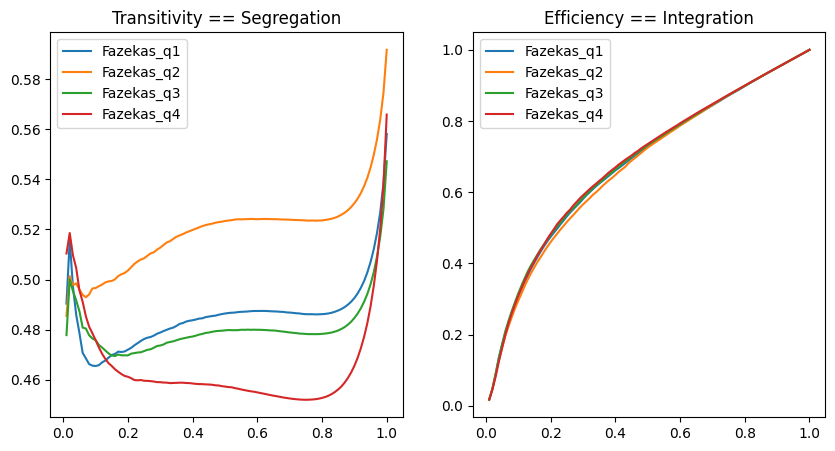

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(121)
order = ["q1", "q2", "q3", "q4"]
for i in order:
    plt.plot(list_thresh[1:], df_int_seg.groupby(["wmh_bin_quant", "Thresh"]).mean(numeric_only = True).loc[i,"Transitivity"], label = f"Fazekas_{i}")
plt.title("Transitivity == Segregation")
plt.legend()
plt.subplot(122)
for i in order:
    plt.plot(list_thresh[1:], df_int_seg.groupby(["wmh_bin_quant", "Thresh"]).mean(numeric_only = True).loc[i,"Efficiency"], label = f"Fazekas_{i}")
plt.title("Efficiency == Integration")
plt.legend()
plt.show()

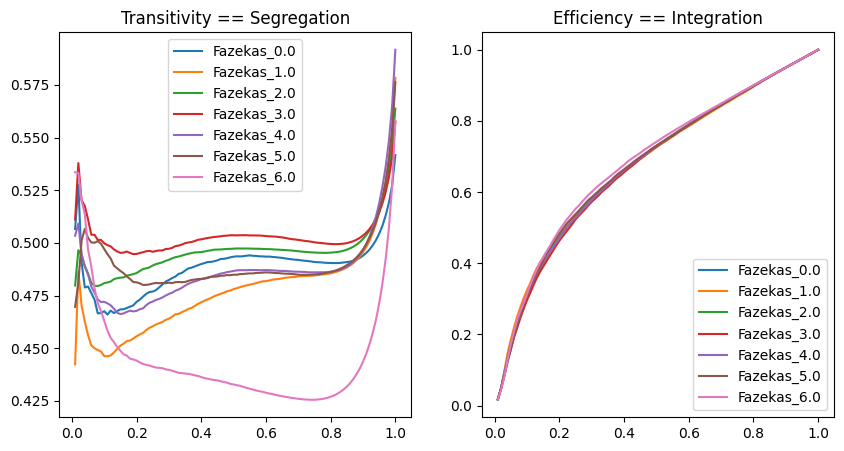

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(121)
order = ["0.0", "1.0", "2.0", "3.0", "4.0", "5.0", "6.0"]
for i in order:
    plt.plot(list_thresh[1:], df_int_seg.groupby(["Fazekas_total", "Thresh"]).mean(numeric_only = True).loc[i,"Transitivity"], label = f"Fazekas_{i}")
plt.title("Transitivity == Segregation")
plt.legend()
plt.subplot(122)
for i in order:
    plt.plot(list_thresh[1:], df_int_seg.groupby(["Fazekas_total", "Thresh"]).mean(numeric_only = True).loc[i,"Efficiency"], label = f"Fazekas_{i}")
plt.title("Efficiency == Integration")
plt.legend()
plt.show()


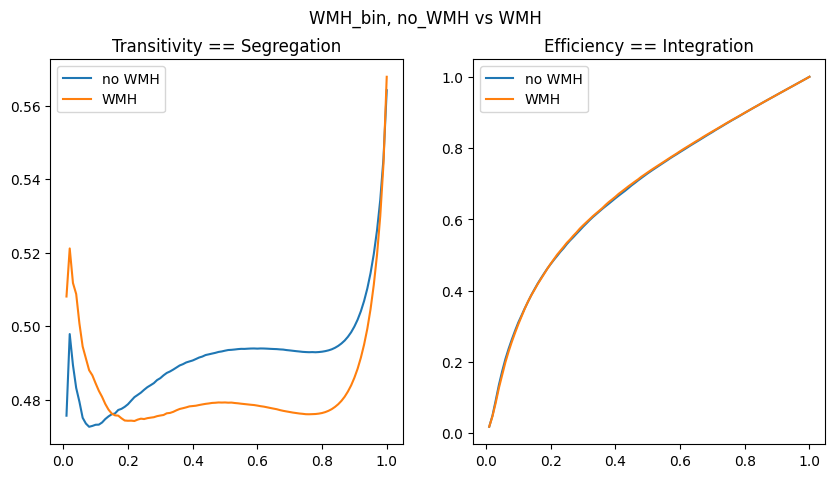

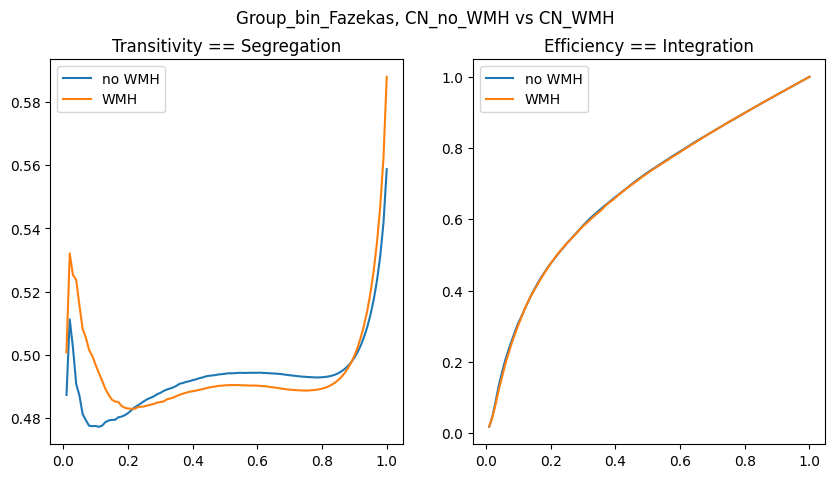

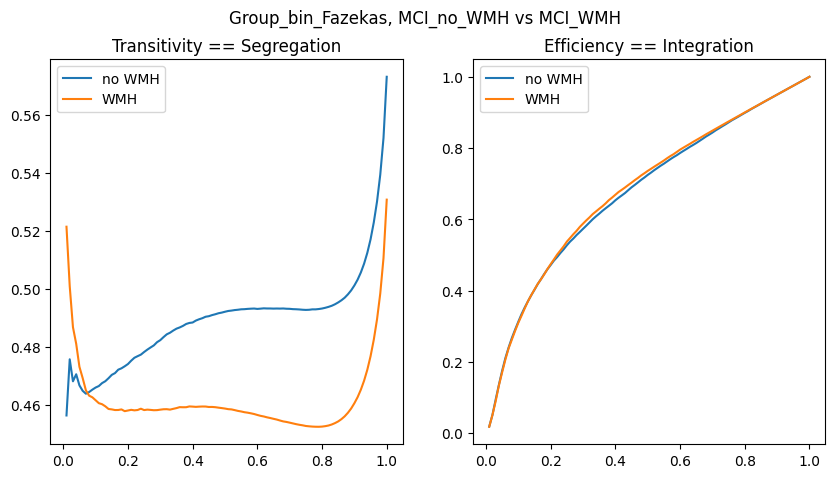

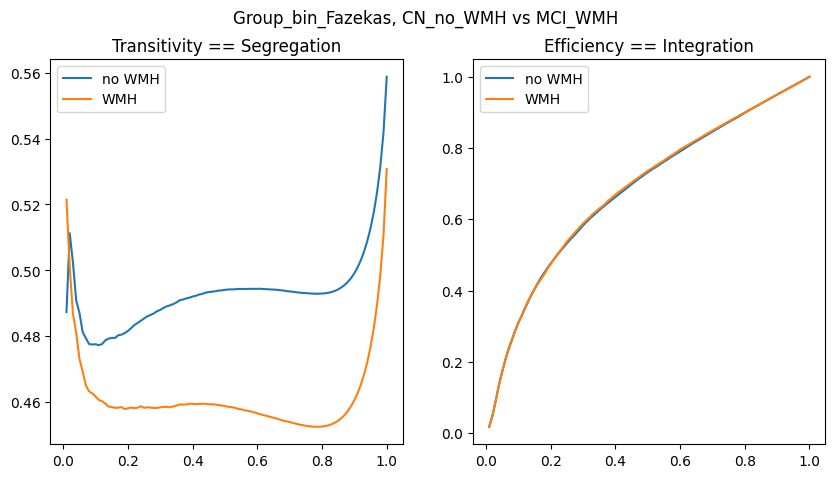

In [9]:
def plot_comparison_int_seg(group_bin, group1, group2):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(list_thresh[1:], df_int_seg.groupby([group_bin, "Thresh"]).mean(numeric_only = True).loc[group1,"Transitivity"], label = "no WMH")
    plt.plot(list_thresh[1:], df_int_seg.groupby([group_bin, "Thresh"]).mean(numeric_only = True).loc[group2, "Transitivity"], label = "WMH")
    plt.title("Transitivity == Segregation")
    plt.legend()
    plt.subplot(122)
    plt.plot(list_thresh[1:], df_int_seg.groupby([group_bin, "Thresh"]).mean(numeric_only = True).loc[group1,"Efficiency"], label = "no WMH")
    plt.plot(list_thresh[1:], df_int_seg.groupby([group_bin, "Thresh"]).mean(numeric_only = True).loc[group2, "Efficiency"], label = "WMH")
    plt.title("Efficiency == Integration")
    plt.legend()
    plt.suptitle(f"{group_bin}, {group1} vs {group2}")
    plt.show()

plot_comparison_int_seg("WMH_bin", "no_WMH", "WMH")
plot_comparison_int_seg("Group_bin_Fazekas", "CN_no_WMH", "CN_WMH")
plot_comparison_int_seg("Group_bin_Fazekas", "MCI_no_WMH", "MCI_WMH")
plot_comparison_int_seg("Group_bin_Fazekas", "CN_no_WMH", "MCI_WMH")


In [10]:
from numpy import trapz
trans_area_noWMH = trapz(df_int_seg.groupby(["WMH_bin", "Thresh"]).mean(numeric_only = True).loc["no_WMH", "Transitivity"].iloc[1: 18], dx=list_thresh[1]-list_thresh[0])
trans_area_WMH = trapz(df_int_seg.groupby(["WMH_bin", "Thresh"]).mean(numeric_only = True).loc["WMH", "Transitivity"].iloc[1:18], dx=list_thresh[1]-list_thresh[0])

### Gustavo's Code

In [11]:
def plot_measure_group_diff(measures, x):
    list_possible_groups = ["WMH_bin", "Group_bin_Fazekas", "Fazekas_total", "wmh_bin_quant"]

    assert x in list_possible_groups, print("Group must be in", list_possible_groups)

    if x == "WMH_bin":
        order = ["no_WMH", "WMH"]
        # Choose the combinations that you want to test..
        pairs = [
            ("no_WMH", "WMH"),
        ]
        labels = ["no WMH", "WMH"]
        x_lab = "WMH group"

    elif x == "Group_bin_Fazekas":
        order = ["CN_no_WMH", "CN_WMH", "MCI_no_WMH", "MCI_WMH"]
        # Choose the combinations that you want to test..
        pairs = [
            ("CN_no_WMH", "CN_WMH"),
            ("MCI_no_WMH", "MCI_WMH"),
            ("CN_no_WMH", "MCI_no_WMH"),
            ("CN_WMH", "MCI_WMH"),
            ("CN_no_WMH", "MCI_WMH")
        ]
        labels = ["CN (no WMH)", "CN (WMH)", "MCI (no WMH)", "MCI (WMH)"]
        x_lab = "Cognitive status (WMH group)"
    
    elif x == "Fazekas_total":
        order = ["0.0", "1.0", "2.0", "3.0", "4.0", "5.0", "6.0",]
        # Choose the combinations that you want to test..
        pairs = [
            ("0.0", "5.0"),
            ("0.0", "6.0"),
            ("1.0", "5.0"),
            ("1.0", "6.0"),
            ("2.0", "5.0"),
            ("2.0", "6.0"),
            ("3.0", "5.0"),
            ("3.0", "6.0"),
            ("4.0", "6.0"),
        ]
        labels = ["0.0", "1.0", "2.0", "3.0", "4.0", "5.0", "6.0",]
        x_lab = "Fazekas total"

    elif x == "wmh_bin_quant":
        order = ["q1", "q2", "q3", "q4"]
        # Choose the combinations that you want to test..
        pairs = [
            ("q1", "q2"),
            ("q1", "q3"),
            ("q1", "q4"),
            ("q2", "q3"),
            ("q2", "q4"),
            ("q3", "q4"),
        ]
        labels = ["q1", "q2", "q3", "q4"]
        x_lab = "WMH quantile"
        
    fig, axs = plt.subplots(nrows=1, ncols = len(measures), figsize = (20, 5))
    axs_flat = axs.flatten()

    for i, ax in enumerate(axs_flat):
        b = sns.boxplot(data=df_petTOAD_meta_synchr, x=x, y=measures[i], order=order, ax = ax)
        ax.set_xticklabels(labels)
        ax.set_xlabel(x_lab)
        annotator = Annotator(
            b, pairs, data=df_petTOAD_meta_synchr, x=x, y=measures[i], order=order,
        )
        annotator.configure(test="t-test_ind", text_format="star", loc="inside", verbose=1)
        annotator.apply_and_annotate()
    fig.tight_layout()
    plt.show()

def plot_wmh_fc_meas(measures):
    fig, axs = plt.subplots(nrows=1, ncols = len(measures), figsize = (15, 5))
    axs_flat = axs.flatten()

    for i, ax in enumerate(axs_flat):
        sns.regplot(ax = ax,
            data=df_petTOAD_meta_synchr,
            x="WMH_load_subj_space",
            y=measures[i],
        )
        ax.set_xlabel("WMH")     
    fig.suptitle("Relationship between WMH and FC measures")
    fig.tight_layout()
    plt.show()

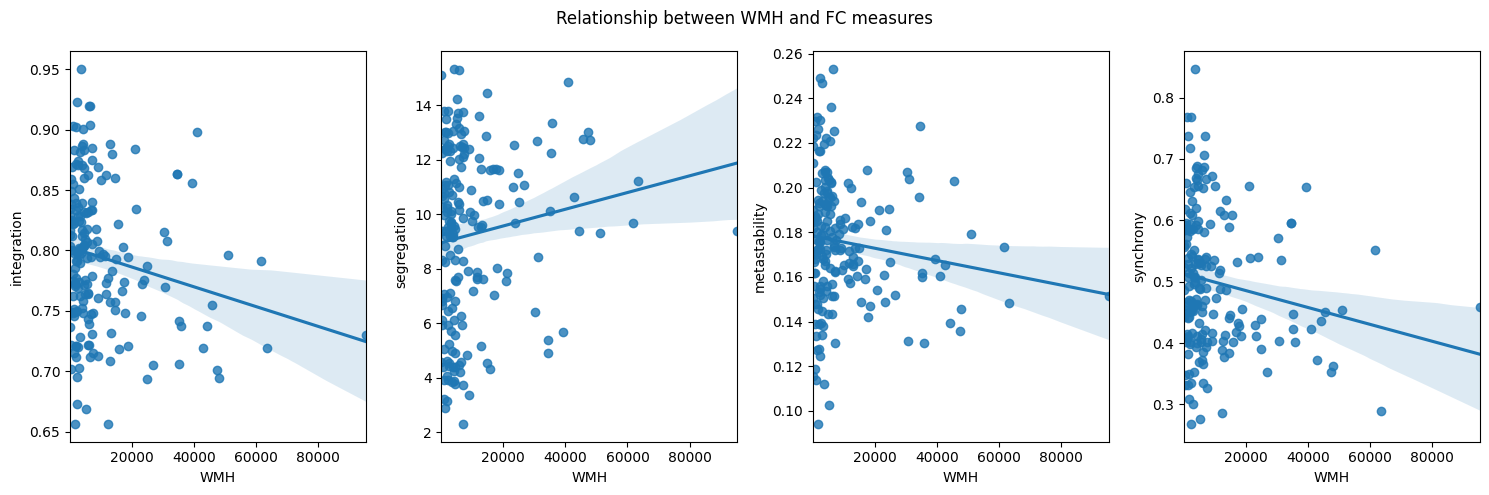

In [12]:
measures = ["integration", "segregation", "metastability", "synchrony"]
plot_wmh_fc_meas(measures)

In [13]:
results_list = []
for meas in measures:
    Y = df_petTOAD_meta_synchr[meas]
    X = df_petTOAD_meta_synchr["WMH_load_subj_space"]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    results_list.append(results.pvalues[1])

df_results_lin_reg_meta_synch =pd.DataFrame({"measure": measures, "p-val": results_list})


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

no_WMH vs. WMH: t-test independent samples, P_val:2.189e-01 t=1.234e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

no_WMH vs. WMH: t-test independent samples, P_val:2.781e-01 t=-1.088e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

no_WMH vs. WMH: t-test independent samples, P_val:5.237e-01 t=6.389e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

no_WMH vs. WMH:

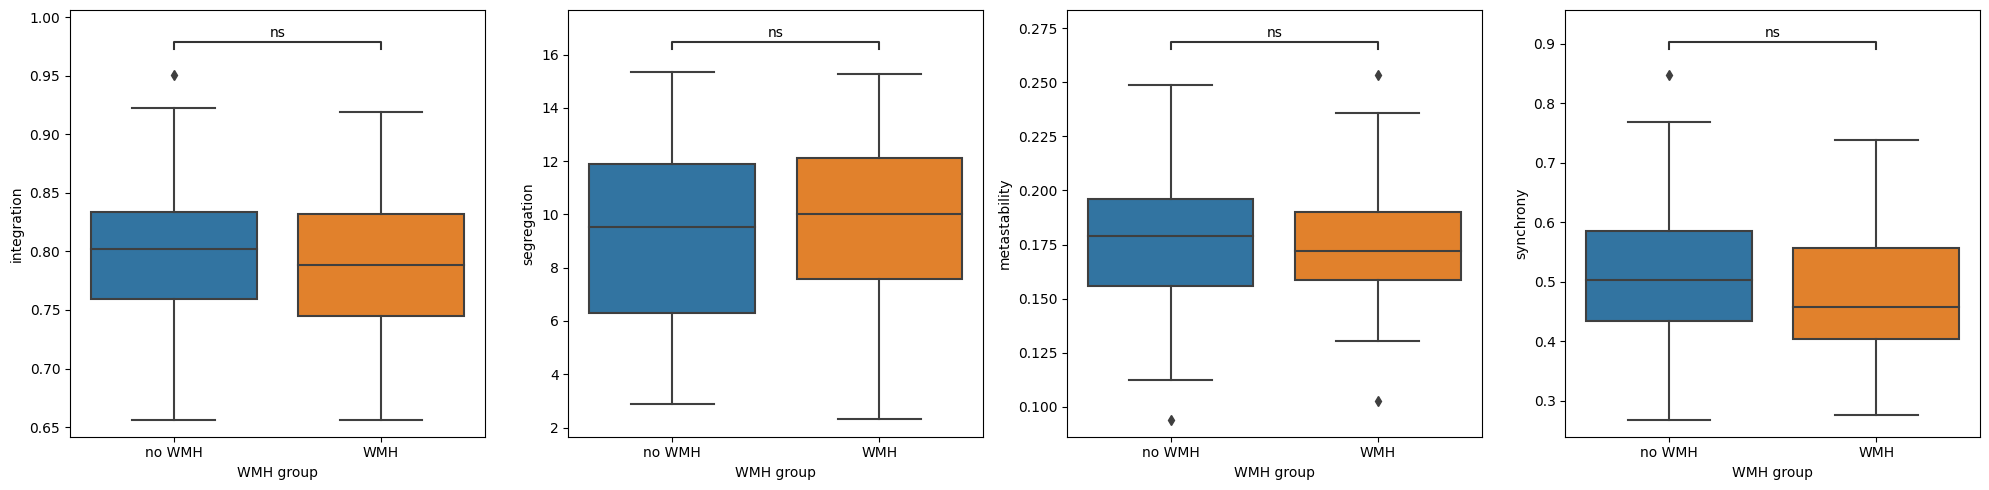

In [14]:
plot_measure_group_diff(measures, "WMH_bin")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CN_no_WMH vs. CN_WMH: t-test independent samples, P_val:5.065e-01 t=6.664e-01
MCI_no_WMH vs. MCI_WMH: t-test independent samples, P_val:2.005e-01 t=1.293e+00
CN_no_WMH vs. MCI_no_WMH: t-test independent samples, P_val:3.460e-01 t=9.470e-01
CN_WMH vs. MCI_WMH: t-test independent samples, P_val:1.119e-01 t=1.606e+00
CN_no_WMH vs. MCI_WMH: t-test independent samples, P_val:1.089e-02 t=2.600e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CN_no_WMH vs. CN_WMH: t-test independent samples, P_val:8.851e-01 t=-1.449e-01
MCI_no_WMH vs. MCI_WMH: t-test independent samples, P_val:1.290e-01 t=-1.537e+00
CN_no_WMH vs. MCI_no_WMH: t-test independent samples, P_val:1

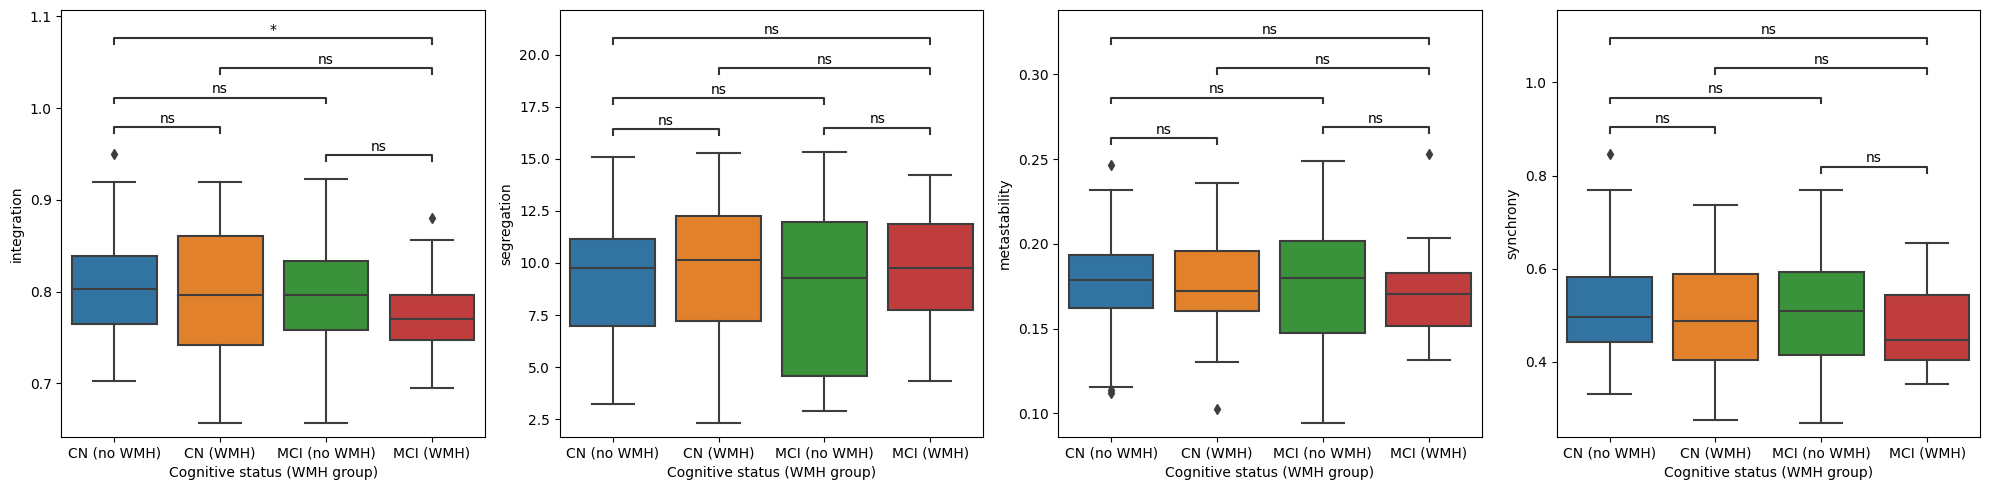

In [15]:
plot_measure_group_diff(measures, "Group_bin_Fazekas")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3.0 vs. 5.0: t-test independent samples, P_val:4.862e-01 t=7.019e-01
4.0 vs. 6.0: t-test independent samples, P_val:1.533e-01 t=1.457e+00
2.0 vs. 5.0: t-test independent samples, P_val:5.107e-01 t=6.606e-01
3.0 vs. 6.0: t-test independent samples, P_val:6.142e-03 t=2.854e+00
1.0 vs. 5.0: t-test independent samples, P_val:9.872e-01 t=-1.623e-02
2.0 vs. 6.0: t-test independent samples, P_val:5.740e-03 t=2.830e+00
0.0 vs. 5.0: t-test independent samples, P_val:7.705e-01 t=2.952e-01
1.0 vs. 6.0: t-test independent samples, P_val:1.648e-01 t=1.416e+00
0.0 vs. 6.0: t-test independent samples, P_val:7.957e-02 t=1.815e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00

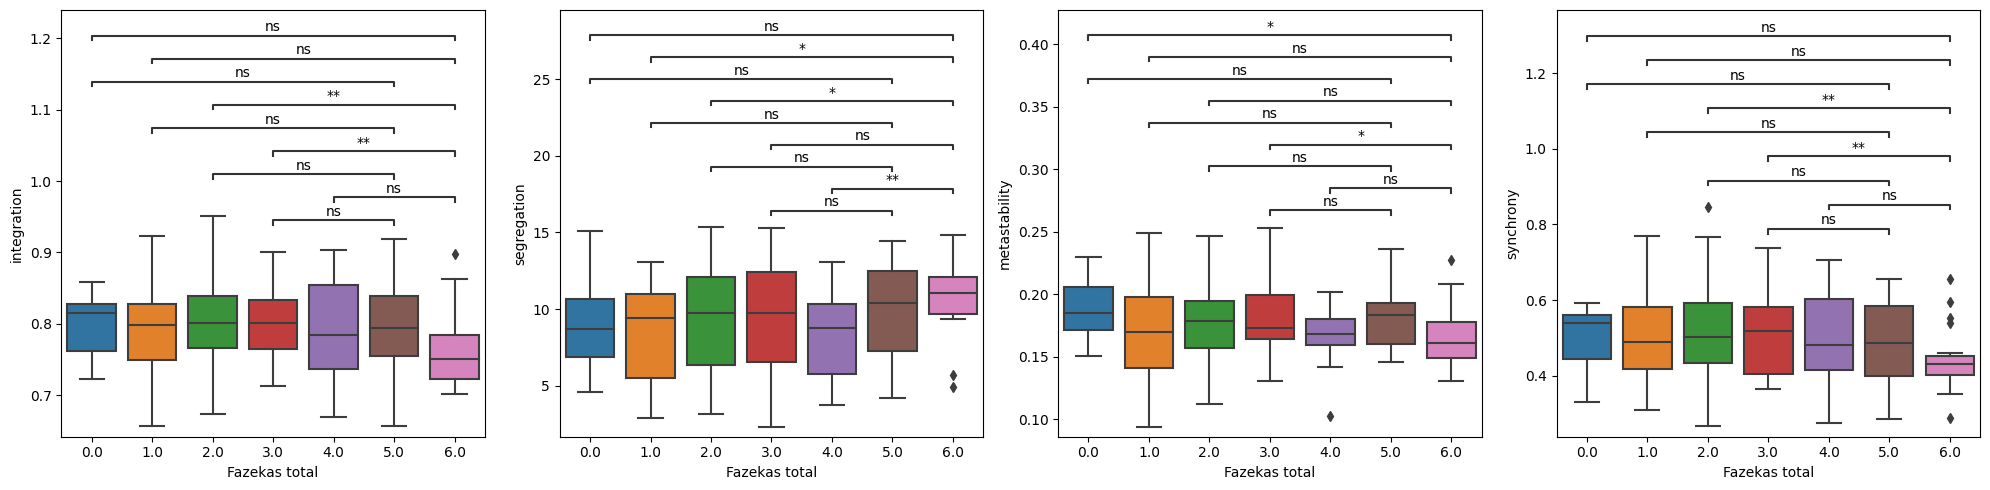

In [16]:
plot_measure_group_diff(measures, "Fazekas_total")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

q1 vs. q2: t-test independent samples, P_val:1.287e-01 t=-1.533e+00
q2 vs. q3: t-test independent samples, P_val:1.942e-01 t=1.308e+00
q3 vs. q4: t-test independent samples, P_val:6.602e-02 t=1.860e+00
q1 vs. q3: t-test independent samples, P_val:8.138e-01 t=-2.362e-01
q2 vs. q4: t-test independent samples, P_val:2.475e-03 t=3.112e+00
q1 vs. q4: t-test independent samples, P_val:1.086e-01 t=1.621e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

q1 vs. q2: t-test independent samples, P_val:4.212e-01 t=8.080e-01
q2 vs. q3: t-test independent samples, P_val:4.545e-02 t=-2.028e+00
q3 vs. q4: t-test independent samples, P_val:6.044e-01 t=-5.198e-01
q1 vs. q3

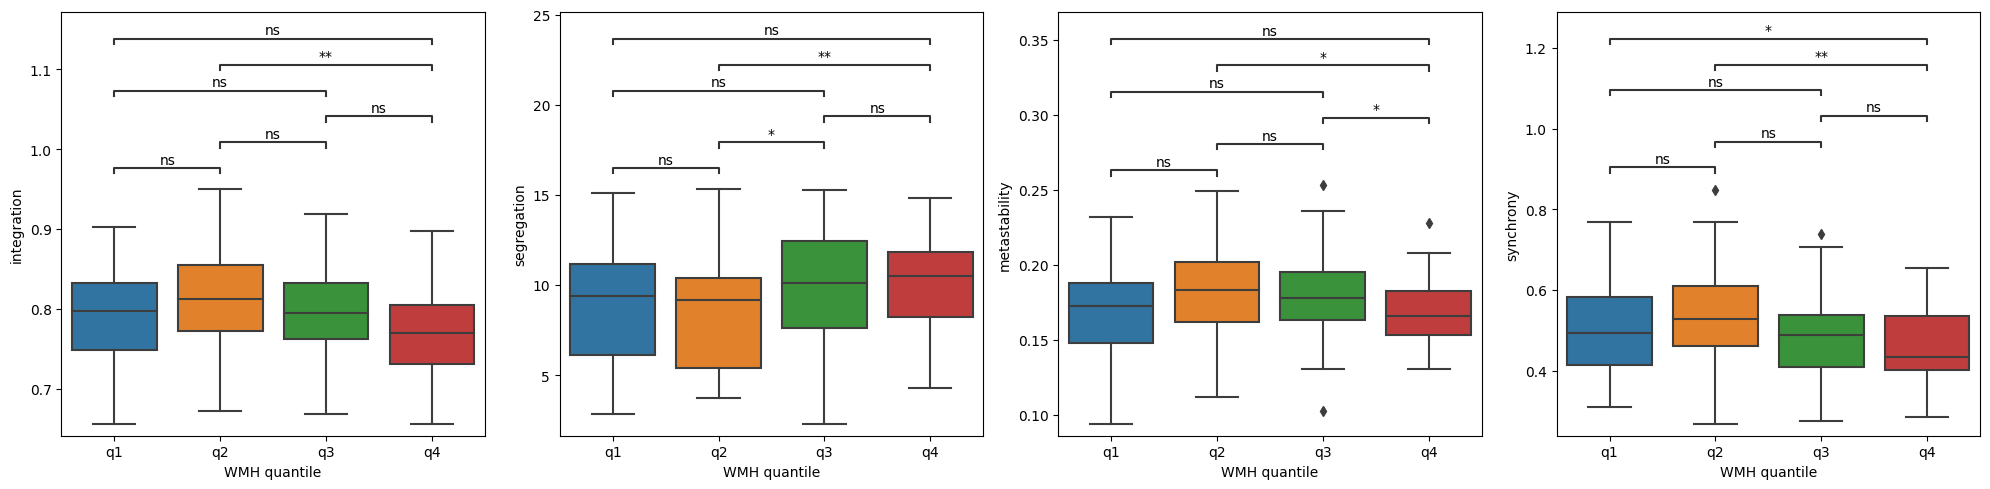

In [17]:
plot_measure_group_diff(measures, "wmh_bin_quant")

In [18]:
fc_cn_no_wmh = []
fc_cn_wmh = []
fc_mci_no_wmh = []
fc_mci_wmh = []

for subj in df_petTOAD["PTID"]:
    if subj not in["ADNI037S6115", "ADNI041S6786"]:
        ts = all_fMRI_clean[subj]
        fc = my_func.fc(ts)
        if subj in CN_no_WMH:
            fc_cn_no_wmh.append(fc)
        elif subj in CN_WMH:
            fc_cn_wmh.append(fc)
        elif subj in MCI_no_WMH:
            fc_mci_no_wmh.append(fc)
        elif subj in MCI_WMH:
            fc_mci_wmh.append(fc)

arr_fc_cn_no_wmh = np.array(fc_cn_no_wmh)
arr_fc_cn_wmh = np.array(fc_cn_wmh)
arr_fc_mci_no_wmh = np.array(fc_mci_no_wmh)
arr_fc_mci_wmh = np.array(fc_mci_wmh)

mean_fc_cn_no_wmh = np.abs(arr_fc_cn_no_wmh.mean(axis=0))
mean_fc_cn_wmh = np.abs(arr_fc_cn_wmh.mean(axis=0))
mean_fc_mci_no_wmh = np.abs(arr_fc_mci_no_wmh.mean(axis=0))
mean_fc_mci_wmh = np.abs(arr_fc_mci_wmh.mean(axis=0))

# int_cn_no_wmh = IntegrationFromFC_Fast(mean_fc_cn_no_wmh)
# seg_cn_no_wmh = computeSegregation(mean_fc_cn_no_wmh)[0]

# int_cn_wmh = IntegrationFromFC_Fast(mean_fc_cn_wmh)
# seg_cn_wmh = computeSegregation(mean_fc_cn_wmh)[0]

# int_mci_no_wmh = IntegrationFromFC_Fast(mean_fc_mci_no_wmh)
# seg_mci_no_wmh = computeSegregation(mean_fc_mci_no_wmh)[0]

# int_mci_wmh = IntegrationFromFC_Fast(mean_fc_mci_wmh)
# seg_mci_wmh = computeSegregation(mean_fc_mci_wmh)[0]


In [33]:
# Function to calculate integration and segregation
def calculate_metrics(arr):
    abs_mean_fc = np.abs(arr)
    integration = IntegrationFromFC_Fast(abs_mean_fc)
    segregation = computeSegregation(abs_mean_fc)[0]
    return integration, segregation

def calculate_random_subsample_integ_segreg():
    # So we want to draw n_random_samples for each group, calculate the average FC out of thes n_random_samples and then
    # calculate the integration and segregation from this averaged FC. We want to keep all the integrations and segregations
    # to compare them between groups.

    n_repeats = 100  # Choose the number of times you want to repeat the random sampling
    # Desired number of random samples. Minimum len(any_group) is 31. I chose 25 at random for now to allow several 
    # combinations also in the group with the least subjects.
    n_random_samples = 25  

    # Dictionary with to store results
    integrations = {'CN_no_WMH': [], 'CN_WMH': [], 'MCI_no_WMH': [], 'MCI_WMH': []}
    segregations = {'CN_no_WMH': [], 'CN_WMH': [], 'MCI_no_WMH': [], 'MCI_WMH': []}

    # Group subjects by condition
    groups = {
        'CN_no_WMH': arr_fc_cn_no_wmh,
        'CN_WMH': arr_fc_cn_wmh,
        'MCI_no_WMH': arr_fc_mci_no_wmh,
        'MCI_WMH': arr_fc_mci_wmh
    }

    for _ in range(n_repeats):
        for group_name, arr_fc in groups.items():
            # Randomly sample n subjects
            random_sample_indices = np.random.choice(arr_fc.shape[0], n_random_samples, replace=False)
            random_sample_data = arr_fc[random_sample_indices]

            # Calculate average connectivity for the random sample
            average_connectivity = np.abs(random_sample_data.mean(axis=0))

            # Calculate metrics for the averaged connectivity
            integration, segregation = calculate_metrics(average_connectivity)

            # Store results
            integrations[group_name].append(integration)
            segregations[group_name].append(segregation)

    # Convert lists to NumPy arrays for easier analysis
    for group_name in groups.keys():
        integrations[group_name] = np.array(integrations[group_name])
        segregations[group_name] = np.array(segregations[group_name])

    df_random_subsample_int = pd.DataFrame(integrations).melt(var_name='Fazekas group', value_name='Integration')
    df_random_subsample_seg = pd.DataFrame(segregations).melt(var_name='Fazekas group', value_name='Segregation')
    df_random_subsample_int.to_csv(RES_DIR / "df-integration-melted_type-subsample_nrand-25_repeat-100.csv")
    df_random_subsample_seg.to_csv(RES_DIR / "df-segregation-melted_type-subsample_nrand-25_repeat-100.csv")
    return df_random_subsample_int, df_random_subsample_seg

In [34]:
try: 
    df_random_subsample_int = pd.read_csv(RES_DIR / "df-integration-melted_type-subsample_nrand-25_repeat-100.csv", index_col=0)
    df_random_subsample_seg = pd.read_csv(RES_DIR / "df-segregation-melted_type-subsample_nrand-25_repeat-100.csv", index_col=0)

except:
    df_random_subsample_int, df_random_subsample_seg = calculate_random_subsample_integ_segreg()

NameError: name 'calculate_random_subsample_integ_segreg' is not defined

In [ ]:
order = ["CN_no_WMH", "CN_WMH", "MCI_no_WMH", "MCI_WMH"]
labels = ["CN no WMH", "CN wmh", "MCI no WMH", "MCI WMH"]
pairs = [
    ("CN_no_WMH", "CN_WMH"),
    ("MCI_no_WMH", "MCI_WMH"),
    ]

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
i = sns.boxplot(data=df_random_subsample_int, x = "Fazekas group", y = "Integration", ax = axs[0])
annotator = Annotator(
    i, pairs, data=df_random_subsample_int, x="Fazekas group", y="Integration", order=order,
)
annotator.configure(test="t-test_ind", text_format="star", loc="inside", verbose=1)
annotator.apply_and_annotate()
axs[0].set_xticklabels(labels)
s = sns.boxplot(data=df_random_subsample_seg, x = "Fazekas group", y = "Segregation", ax = axs[1])
annotator = Annotator(
    s, pairs, data=df_random_subsample_seg, x="Fazekas group", y="Segregation", order=order,
)
annotator.configure(test="t-test_ind", text_format="star", loc="inside", verbose=1)
annotator.apply_and_annotate()
axs[1].set_xticklabels(labels)

In [31]:
# for subj in df_petTOAD["PTID"]:
#     if subj in CN_no_WMH:
#         savedir = DATA_DIR / "fcd" / "cn_no_wmh"
#     elif subj in CN_WMH:
#         savedir = DATA_DIR / "fcd" / "cn_wmh"
#     elif subj in MCI_no_WMH:
#         savedir = DATA_DIR / "fcd" / "mci_no_wmh"
#     elif subj in MCI_WMH:
#         savedir = DATA_DIR / "fcd" / "mci_wmh"
#     if not Path.exists(savedir):
#         Path.mkdir(savedir)
#     ts = all_fMRI_clean[subj].T
#     np.savetxt(savedir / f"sub-{subj}_timeseries_demeaned_detrended_z.csv", ts, delimiter = ",")
